# Example Arbor

Example utilizing the `LFPykit` module for predictions of
current dipole moment from a dendritic stick model set up in Arbor (https://github.com/arbor-sim/arbor).
The passive stick receives sinusoid synaptic current input at its terminal
segment.

In [1]:
%matplotlib inline

In [2]:
## arbor may be installed using pip:
#!pip install git+https://github.com/espenhgn/arbor@sinsyn#egg=arbor  # adds sinsyn mechanism

In [3]:
# import modules
import numpy as np
import arbor
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [4]:
class Recipe (arbor.recipe):
    def __init__(self, cell):
        super().__init__()
     
        self.the_cell = cell

        self.vprobe_id = (0, 0)
        self.iprobe_id = (0, 1)

        self.the_props = arbor.neuron_cable_properties()
        self.the_cat = arbor.default_catalogue()
        self.the_props.register(self.the_cat)
       
    def num_cells(self):
        return 1

    def num_sources(self, gid):
        return 0

    def cell_kind(self, gid):
        return arbor.cell_kind.cable

    def cell_description(self, gid):
        return self.the_cell

    def global_properties(self, kind):
        return self.the_props
    
    def probes(self, gid):
        return [
            arbor.cable_probe_membrane_voltage_cell(),
            arbor.cable_probe_total_current_cell()
        ]
    
# define segment tree
tree = arbor.segment_tree()
tree.append(arbor.mnpos, 
            arbor.mpoint(0, 0, 0, 1), 
            arbor.mpoint(0, 0, 200, 1), tag=1)

# define morphology (needed for arbor.place_pwlin)
morphology = arbor.morphology(tree)

# define relative locations (segment midpoints)
nseg = 41
locations = (np.arange(nseg) + 0.5) / nseg

# labels
labels = arbor.label_dict()
# Label dictionary
labels = arbor.label_dict()

# decor
decor = arbor.decor()

# set initial voltage, temperature, axial resistivity, membrane capacitance
decor.set_property(
    Vm=-65,  # Initial membrane voltage [mV]
    tempK=300,  # Temperature [Kelvin]
    rL=1000,  # Axial resistivity [Ω cm]
    cm=0.01,  # Membrane capacitance [F/m**2]
)

# set passive mechanism all over
pas = arbor.mechanism('pas')
pas.set('g', 0.0001)  # leak conductivity (S/cm2)
pas.set('e', -65)  # leak reversal potential (mV)
decor.paint('(all)', pas)

# set sinusoid input current at mid point of terminating CV (segment)
sinsyn = arbor.mechanism('sinsyn')
sinsyn.set('dur', 1E8)  # stimulation duration (ms)
sinsyn.set('pkamp', 0.001)  # stimulation amplitude (nA)
sinsyn.set('freq', 100)  # stimulation frequency (Hz)
decor.place('(location 0 {})'.format(locations[-1]), sinsyn)

# number of CVs per branch
policy = arbor.cv_policy_fixed_per_branch(nseg)
decor.discretization(policy)

# create cell and set properties
cell = arbor.cable_cell(tree, labels, decor)

# create single cell model
model = arbor.single_cell_model(cell)

# instantiate recipe with cell
recipe = Recipe(cell)

# instantiate simulation
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

# set up sampling on probes
schedule = arbor.regular_schedule(0.1)
v_handle = sim.sample(recipe.vprobe_id, schedule, arbor.sampling_policy.exact)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)

# run simulation for 500 ms of simulated activity and collect results.
sim.run(tfinal=500)

# extract time, V_m and I_m for each compartment
V_m_samples, V_m_meta = sim.samples(v_handle)[0]
I_m_samples, I_m_meta = sim.samples(i_handle)[0]

# note: the cables comprising the metadata for each probe
# should be the same, as well as the reported sample times.
assert V_m_meta==I_m_meta
assert (V_m_samples[:, 0]==I_m_samples[:, 0]).all()

# prep recorded data for plotting
time = V_m_samples[:, 0]
V_m = V_m_samples[:, 1:].T
I_m = I_m_samples[:, 1:].T

In [5]:
# Collect CV geometry data using arbor's place_pwlin methoood
p = arbor.place_pwlin(morphology)
x, y, z, d = [], [], [], []
for m in I_m_meta:
    (seg, ) = p.segments([m])
    x.append([seg.prox.x, seg.dist.x])
    y.append([seg.prox.y, seg.dist.y])
    z.append([seg.prox.z, seg.dist.z])
    d.append([seg.prox.radius * 2, seg.dist.radius * 2])

In [6]:
# Create CellGeometry instance with geometry data to facilitate forward-model predictions
cell_geometry = lfpykit.CellGeometry(np.array(x), 
                                     np.array(y),
                                     np.array(z),
                                     np.array(d))

In [7]:
# membrane voltages, transmemrbane current and corresponding times
cell_geometry.V_m = V_m  # mV
cell_geometry.I_m = I_m  # nA
cell_geometry.time = time # ms

In [8]:
# compute current dipole moment
cdm = lfpykit.CurrentDipoleMoment(cell=cell_geometry)
M = cdm.get_transformation_matrix()
P = M @ cell_geometry.I_m  # µm*nA

In [9]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

Text(0.5, 0, '$t$ (ms)')

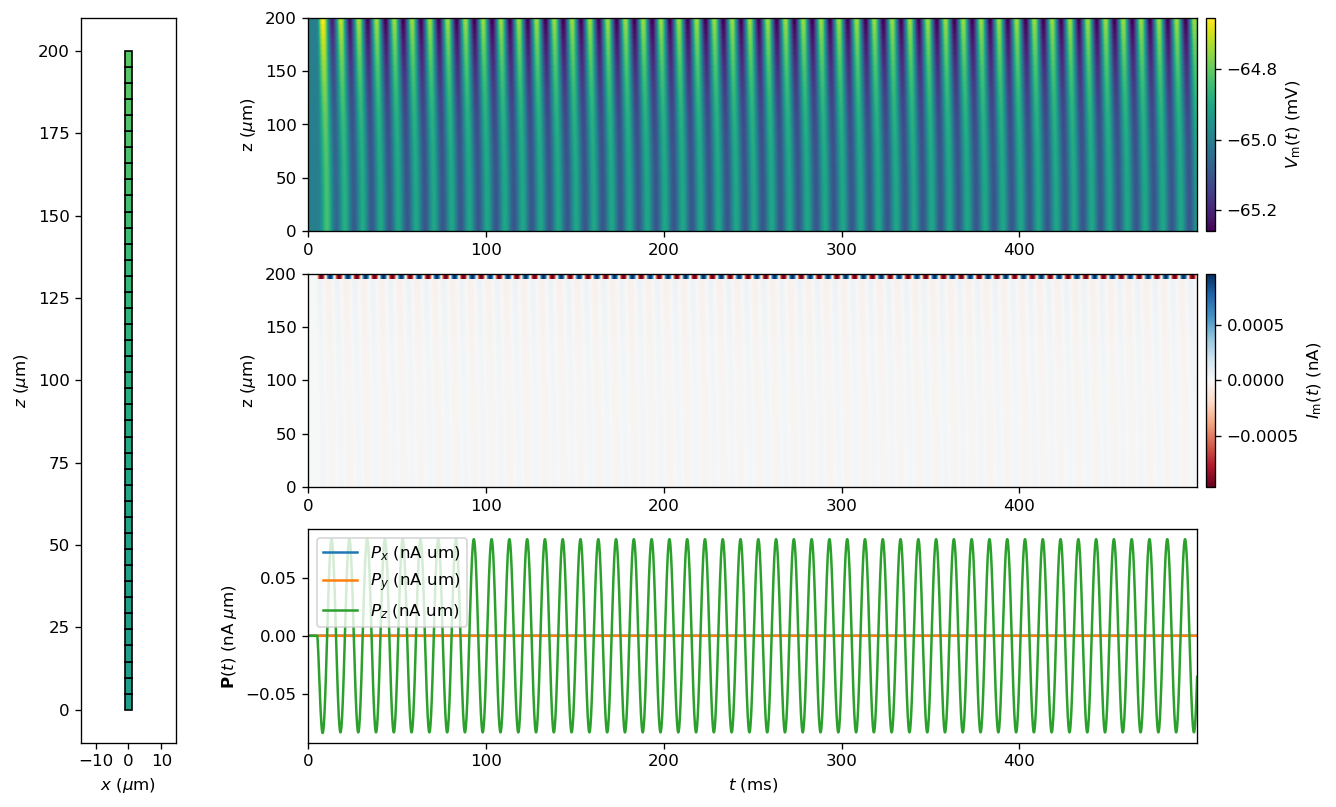

In [10]:
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 10)
# morphology
ax0 = fig.add_subplot(gs[:, 0])
norm = plt.Normalize(vmin=cell_geometry.V_m.min(), vmax=cell_geometry.V_m.max())
for z, d, v in zip(cell_geometry.z, cell_geometry.d.mean(axis=-1), cell_geometry.V_m[:, -1]):
    ax0.add_patch(plt.Rectangle((-d / 2, z[0]), d, z[1] - z[0],
                                ec='k', fc=plt.cm.viridis(norm(v))))
ax0.axis(ax0.axis('equal'))
ax0.set_xlabel(r'$x$ ($\mu$m)')
ax0.set_ylabel(r'$z$ ($\mu$m)')

# membrane voltage
ax1 = fig.add_subplot(gs[0, 2:])
im1 = ax1.pcolormesh(cell_geometry.time, cell_geometry.z.mean(axis=-1), cell_geometry.V_m,
                     shading='auto', norm=norm)
ax1.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax1, im1)
cb.set_label(r'$V_\mathrm{m}(t)$ (mV)')

# membrane current
ax2 = fig.add_subplot(gs[1, 2:], sharex=ax1, sharey=ax1)
im2 = ax2.pcolormesh(cell_geometry.time, cell_geometry.z.mean(axis=-1), cell_geometry.I_m,
                     cmap='RdBu', shading='auto')
ax2.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax2, im2)
cb.set_label(r'$I_\mathrm{m}(t)$ (nA)')

# current dipole moment
ax3 = fig.add_subplot(gs[2, 2:], sharex=ax1)
ax3.plot(cell_geometry.time, P.T)
ax3.legend([r'$P_x$ (nA um)', r'$P_y$ (nA um)', r'$P_z$ (nA um)'])
ax3.set_ylabel(r'$\mathbf{P}(t)$ (nA $\mu$m)')
ax3.set_xlabel('$t$ (ms)')